# Regression on subgroups
This Notebook will look in more detail at some factors that affect the connection between the number of casualties and vehicles in an accident. It does this by splitting the accidents dataset into two groups: those involving bus-like vehicles and those that don't, and comparing regression tests between the two groups.

In [1]:
# Import the required libraries

import pymongo
import datetime
import collections

import pandas as pd
import scipy.stats

In [2]:
# Open a connection to the Mongo server, open the accidents database and name the collections of accidents and labels
client = pymongo.MongoClient('mongodb://localhost:27351/')

db = client.accidents
accidents = db.accidents
labels = db.labels

In [3]:
# Load the expanded names of keys and human-readable codes into memory

expanded_name = collections.defaultdict(str)
for e in labels.find({'expanded': {"$exists": True}}):
    expanded_name[e['label']] = e['expanded']
    
label_of = collections.defaultdict(str)
for l in labels.find({'codes': {"$exists": True}}):
    for c in l['codes']:
        try:
            label_of[l['label'], int(c)] = l['codes'][c]
        except ValueError: 
            label_of[l['label'], c] = l['codes'][c]

## Pearson's *R*²
Let's look again at the whole set.

In [4]:
# Build a DataFrame, one row for each accident
cas_veh_unrolled_df = pd.DataFrame(list(accidents.find({}, ['Number_of_Casualties', 'Number_of_Vehicles'])))

# Count the number of each severity
cas_veh_df = pd.crosstab(cas_veh_unrolled_df['Number_of_Casualties'], 
                                      cas_veh_unrolled_df['Number_of_Vehicles'])
# Reshape
cas_veh_long_df = cas_veh_df.stack().reset_index()
cas_veh_long_df

,Number_of_Casualties,Number_of_Vehicles,0
0,1,1,39217
1,1,2,65680
2,1,3,6168
3,1,4,1056
4,1,5,197
5,1,6,76
6,1,7,27
7,1,8,4
8,1,9,1
9,1,10,1


In [6]:
regressionline = scipy.stats.linregress(cas_veh_unrolled_df['Number_of_Casualties'],
                                       cas_veh_unrolled_df['Number_of_Vehicles'])

# The regression line is of the form y = m x + b
m = regressionline[0]
b = regressionline[1]
(m, b)

(0.21101011188488891, 1.542734939456031)

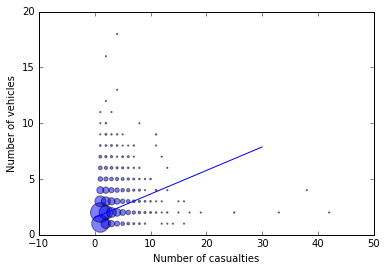

In [7]:
plt.scatter(cas_veh_long_df['Number_of_Casualties'], 
            cas_veh_long_df['Number_of_Vehicles'],
            s=np.sqrt(cas_veh_long_df[0])*1.5,
            alpha=0.5
            )

x = np.linspace(0, 30, 20)
plt.plot(x, m*x + b)

plt.xlabel('Number of casualties')
plt.ylabel('Number of vehicles')
plt.show()

The `pearsonr` function calculates Pearson's *R*² value of correlation. Recall that values near +1 show good positive correlation, values near -1 show good negative correlation, and values near 0 show no particular correlation. The `scipy` function returns a second value, the *p* value of the result. 

In [8]:
scipy.stats.pearsonr(cas_veh_unrolled_df['Number_of_Casualties'], 
                     cas_veh_unrolled_df['Number_of_Vehicles'])

(0.24158490939232527, 0.0)

This result shows a small, positive correlation with a very small *p* value. In other words, there's not much correlation, and the result is statistically significant. This means we can reject the the null hypothesis that the number of casualties in an accident is unrelated to the number of vehicles.

Looking at the data, it seems to be a result that most accidents result in very few casualties, and the accidents with the most casualties have few vehicles.

Let's look at why the accidents with most casualties seem to only involve a few vehicles. 

### Activity 1
Investigate the types of vehicles that are involved in the largest accidents (i.e. those accidents with more than 8 casualties). What types of vehicles appear in the multiple-casualty accidents?

For each accident with more than 8 casualties, list the vehicles involved. For each vehicle, print the type of vehicle and the number of casualties in it, in a format similar to this:

```
Acc index 201201GD10531; 9 casualties, 3 vehicles
	Car: 1 casualties
	Car: 5 casualties
	Bus: 3 casualties
Acc index 201201KF60687; 11 casualties, 3 vehicles
	Taxi/Private: 2 casualties
	Taxi/Private: 4 casualties
	Taxi/Private: 5 casualties
```

**Hint**

Because you'll want to look at the vehicles involved in each accident, it's easier to keep the data in standard Python data structures, unchanged from the result of a pymongo `find()`.

The solution is in the [`14.4solutions`](14.4solutions.ipynb) Notebook.

In [101]:
# Insert your solution here.
#accidents.find_one({'Number_of_Casualties' : {'$gt':8}})
big_accidents = [a for a in accidents.find({'Number_of_Casualties' : {'$gt':8}})]
for a in big_accidents:
    print("Acc index: " + format(a['Accident_Index']) + "; " 
          + str(len(a['Casualties'])) + " Casualties, " 
          + str(len(a['Vehicles'])) + " Vehicles")
    for v in a['Vehicles']:
        print(format(label_of['Vehicle_Type', v['Vehicle_Type']]) + "(" + format(v['Vehicle_Type']) + "): "
             + format(len([c for c in a['Casualties'] if c['Vehicle_Reference'] == v['Vehicle_Reference']])) + " Casualties")

Acc index: 201201GD10531; 9 Casualties, 3 Vehicles
Car(9): 1 Casualties
Car(9): 5 Casualties
Bus or coach (17 or more pass seats)(11): 3 Casualties
Acc index: 201201KF60687; 11 Casualties, 3 Vehicles
Taxi/Private hire car(8): 2 Casualties
Taxi/Private hire car(8): 4 Casualties
Taxi/Private hire car(8): 5 Casualties
Acc index: 201201WW50958; 10 Casualties, 3 Vehicles
Car(9): 4 Casualties
Taxi/Private hire car(8): 3 Casualties
Car(9): 3 Casualties
Acc index: 201204EA12275; 9 Casualties, 2 Vehicles
Car(9): 0 Casualties
Minibus (8 - 16 passenger seats)(10): 9 Casualties
Acc index: 201205EE01017; 9 Casualties, 2 Vehicles
Car(9): 4 Casualties
Bus or coach (17 or more pass seats)(11): 5 Casualties
Acc index: 201205EE03703; 12 Casualties, 1 Vehicles
Bus or coach (17 or more pass seats)(11): 12 Casualties
Acc index: 201205EE06006; 9 Casualties, 3 Vehicles
Car(9): 3 Casualties
Car(9): 4 Casualties
Car(9): 2 Casualties
Acc index: 201205FF02477; 9 Casualties, 2 Vehicles
Car(9): 0 Casualties
Car(9)

### Activity 2
Separate out the types of accidents into those involving bus-like vehicles and those that don't, and calculate the regression scores for the subgroups.

The solution is in the [`14.4solutions`](14.4solutions.ipynb) Notebook.

In [114]:
# Insert your solution here.
coach_unrolled_df = pd.DataFrame(list(accidents.find({'Vehicles.Vehicle_Type': {'$in': [10, 11]}}, 
                                                       ['Number_of_Casualties', 'Number_of_Vehicles'])))
non_coach_unrolled_df = pd.DataFrame(list(accidents.find({'Vehicles.Vehicle_Type': {'$not': {'$in': [10, 11]}}}, 
                                                       ['Number_of_Casualties', 'Number_of_Vehicles'])))
coach_df = pd.crosstab(coach_unrolled_df['Number_of_Casualties'], 
                                      coach_unrolled_df['Number_of_Vehicles'])
coach_df

Number_of_Vehicles,1,2,3,4,5,6,7,11
Number_of_Casualties,,,,,,,,
1,2949,2228,234,32,4,3,1,1
2,204,530,98,15,6,2,0,0
3,51,205,36,13,3,1,1,1
4,22,86,16,9,0,1,0,0
5,7,54,5,0,1,0,1,0
6,6,31,4,2,1,0,0,0
7,3,17,0,2,0,0,0,0
8,4,9,3,1,0,0,0,0
9,1,7,2,0,0,0,0,0


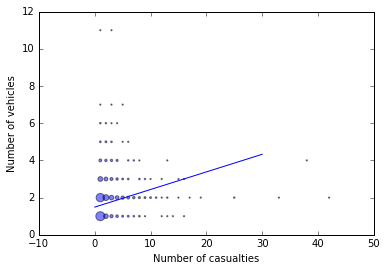

In [116]:
coach_regressionline = scipy.stats.linregress(coach_unrolled_df['Number_of_Casualties'],
                                       coach_unrolled_df['Number_of_Vehicles'])
coach_m = coach_regressionline[0]
coach_b = coach_regressionline[1]
(coach_m, coach_b)
coach_long_df = coach_df.stack().reset_index()
coach_long_df

plt.scatter(coach_long_df['Number_of_Casualties'], 
            coach_long_df['Number_of_Vehicles'],
            s=np.sqrt(coach_long_df[0])*1.5,
            alpha=0.5
            )

x = np.linspace(0, 30, 20)
plt.plot(x, coach_m*x + coach_b)

plt.xlabel('Number of casualties')
plt.ylabel('Number of vehicles')
plt.show()

## What next?
If you are working through this Notebook as part of an inline exercise, return to the module materials now.

If you are working through this set of Notebooks as a whole, you've completed the Part 14 Notebooks. It's time to move on to Part 15.

In [117]:
scipy.stats.pearsonr(coach_unrolled_df['Number_of_Casualties'], 
                     coach_unrolled_df['Number_of_Vehicles'])

(0.19583731511182581, 5.7796300308614737e-61)